# Results and comparison of ARIMA and G-VAR 

In [5]:
import statsmodels.api as sm
import seaborn as sns

import numpy as np
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import pickle # to access dataframe faster than csv
import glob, re
import os
import csv
from pathlib import Path
import scipy as sp
import networkx
import torch_geometric
import torch
import utils
%load_ext autoreload
%autoreload 2
import arima.arima as arima
from utils import get_train_batch_blocks,blocked_cross_validation_idx

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(8, 8))
plt.rc("font", size=14)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
filepath = "./uk-smart-meter-aggregated/"
filename = "df_agg.pkl"
# load pickle file
with open(filepath+filename, "rb") as f:
    df_agg = pickle.load(f)
df_agg.head()

,2,3,4,6,7,8,9,10,11,12,...,5535,5536,5537,5538,5541,5549,5550,5551,5557,5564
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Load sparse matrix from file
adjacency_matrix = sp.sparse.load_npz("Results/adjacency_matrix.npz")
adjacency_matrix

<5558x5558 sparse array of type '<class 'numpy.float64'>'
	with 1829860 stored elements (blocksize = 2x2) in Block Sparse Row format>

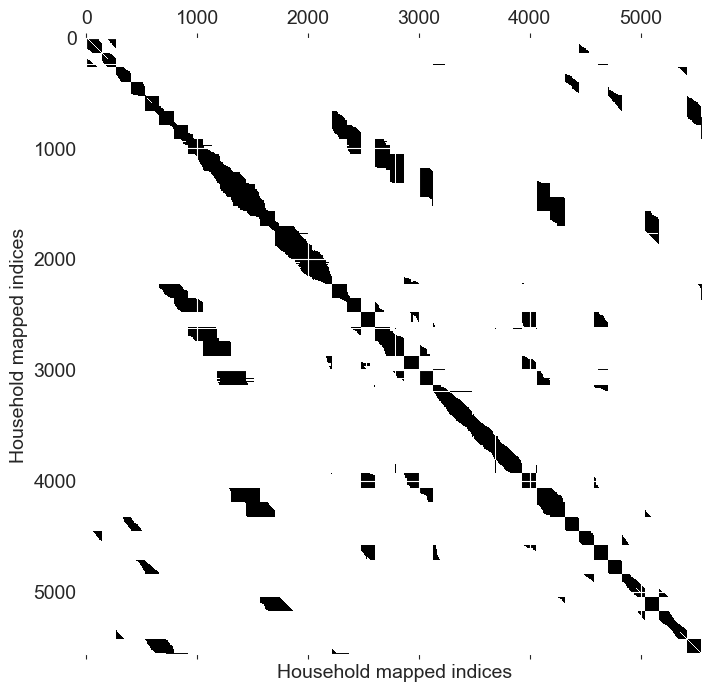

In [8]:
plt.spy(sp.sparse.bsr_matrix.toarray(adjacency_matrix))
plt.xlabel("Household mapped indices")
plt.ylabel("Household mapped indices")
plt.show()

In [9]:
df = pd.DataFrame({
    'DateTime': pd.date_range(start='2012-01-01 00:00:00', end='2013-12-31 23:00:00', freq='1h')
})
train_months=2
test_months=1
batch_size=48
overlap_months=0
# Training data
train_test_blocks=blocked_cross_validation_idx(df, train_months, test_months, overlap_months)[0]
batch_windows = get_train_batch_blocks(train_test_blocks[0],train_test_blocks[1],batch_size=batch_size)
# Validation data
validation_data=blocked_cross_validation_idx(df,train_months,test_months,overlap_months)[1]
validation_batch_windows = get_train_batch_blocks(validation_data[0],validation_data[1],batch_size=batch_size)

In [10]:
print("(start training, end training, start testing, end testing), (start validation, end validation, start rest, end rest)")
print(train_test_blocks, validation_data)

(start training, end training, start testing, end testing), (start validation, end validation, start rest, end rest)
(0, 1439, 1440, 2183) (2184, 3647, 3648, 4367)


In [15]:
df.loc[6527]

DateTime   2012-09-28 23:00:00
Name: 6527, dtype: datetime64[ns]

In [14]:
df[df['DateTime'].dt.date==pd.to_datetime('2012-09-24').date()]

,DateTime
6408,2012-09-24 00:00:00
6409,2012-09-24 01:00:00
6410,2012-09-24 02:00:00
6411,2012-09-24 03:00:00
6412,2012-09-24 04:00:00
6413,2012-09-24 05:00:00
6414,2012-09-24 06:00:00
6415,2012-09-24 07:00:00
6416,2012-09-24 08:00:00
6417,2012-09-24 09:00:00


In [68]:
val_dataset = utils.TemporalGraphDataset(adjacency_matrix, df_agg)
for b, window_idx in enumerate(validation_batch_windows):
    val_dataset.add_batch_instance(window_idx, b)

## Load G-VAR model

In [196]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model
in_channels = 1 # 1 feature
out_channels = 1 # 1 feature
K = 2 # order of polynomial filter
P = 12 # window size

model_gvar = utils.TemporalGCN(in_channels, out_channels, K, P).to(device)
# # Load the model parameters
model_gvar.load_state_dict(torch.load('models/model_parameters_T12_K2_Epoch200.pth'))
model_gvar.eval()  # Set the model to evaluation mode if you are using it for inference

TemporalGCN(
  (gcn_layer): TemporalGCNLayer()
)

In [100]:
val_dataset.get_batch_instance(0)[2184]

Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052])

In [101]:
len(val_dataset.get_batch_instance(0).keys())

48

In [102]:
# def forward(self, dataset) -> Tensor:
#     # keys of the given dataset as tensor
#     indices = torch.Tensor(list(dataset.keys())).int()
#     batch_size = len(indices) # 128
#     first_idx = indices[0].item() # since it is a tensor

#     # Intialize output tensor # (428, 104)
#     out = torch.zeros(dataset[first_idx].x.shape[0], batch_size - self.P).to(device)

#     # Cache adjacency matrices and feature matrices
#     adj_matrices = []
#     x_t_matrices = []

#     for i in range(first_idx, first_idx + batch_size):
#         edge_index = dataset[i].edge_index.long().to(device)
#         edge_weight = dataset[i].edge_weight.to(device)
#         adj_sparse_tensor = SparseTensor(row = edge_index[0], col = edge_index[1], value = edge_weight)
#         adj_matrices.append(adj_sparse_tensor)
#         x_t_matrices.append(dataset[i].x.to(device))

#     # Compute the output using cached matrices
#     for i_p in range(batch_size - self.P):
#         out_kp = torch.zeros_like(x_t_matrices[0]).to(device)

#         for p in range(self.P):
#             idx = i_p + p
#             x_t_minus_p = x_t_matrices[idx]
#             adj_sparse_tensor = adj_matrices[idx]

#             for k in range(self.K + 1):
#                 h_kp = self.h[k, p]
#                 out_kp += h_kp * self.propagate(adj_sparse_tensor, x = x_t_minus_p, k = k)

#         out[:, i_p] = out_kp.view(-1)

#     return self.m(out)

# def propagate(self, adj_sparse_tensor, x = None, k = 1):
#     x_out = x
#     for _ in range(k):
#         x_out = adj_sparse_tensor.matmul(x_out)
#     return x_out

In [183]:
print(f"Length P: {len(val_dataset.get_batch_instance(0).keys())} and number nodes first batch: {val_dataset.get_batch_instance(0)[2184].x.shape[0]}")

Length P: 48 and number nodes first batch: 1266


## Load G-VAR from parameter dict

In [212]:
batch = validation_batch_windows[0]
# Forward pass
predict = model_gvar(val_dataset.get_batch_instance(0))

target = utils.get_target(batch, val_dataset.get_all_nodes(0), P, df_agg)
print(predict[0,:6])
print(target[0, :6])

tensor([0., 0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)
tensor([0.1590, 0.2360, 0.1430, 0.1070, 0.2000, 0.1710])


In [179]:
predict[0:10], target[0:10]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0803, 0.0794, 0.0668, 0.0694, 0.0726, 0.0677, 0.0615, 0.0559, 0.0596,
          0.1151, 0.1143, 0.1047, 0.0980, 0.0911, 0.0914, 0.0914, 0.1224, 0.1145,
          0.1192, 0.1164, 0.1167, 0.0736, 0.0741, 0.0662, 0.0671, 0.0745, 0.1513,
          0.1560, 0.1194, 0.1148, 0.1255, 0.1196, 0.1243, 0.1513, 0.1519, 0.1904],
         [0.0

## Select household at three different timeframes

In [142]:
# Set seed for reproducibility
seed = 1984
np.random.seed(seed)
node_list = np.array(list(val_dataset.get_all_nodes(0)))
random_households = node_list[np.random.choice(len(node_list), 5)]
random_households

array([ 233, 5255,  151, 4492, 4467])

array([<Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>], dtype=object)

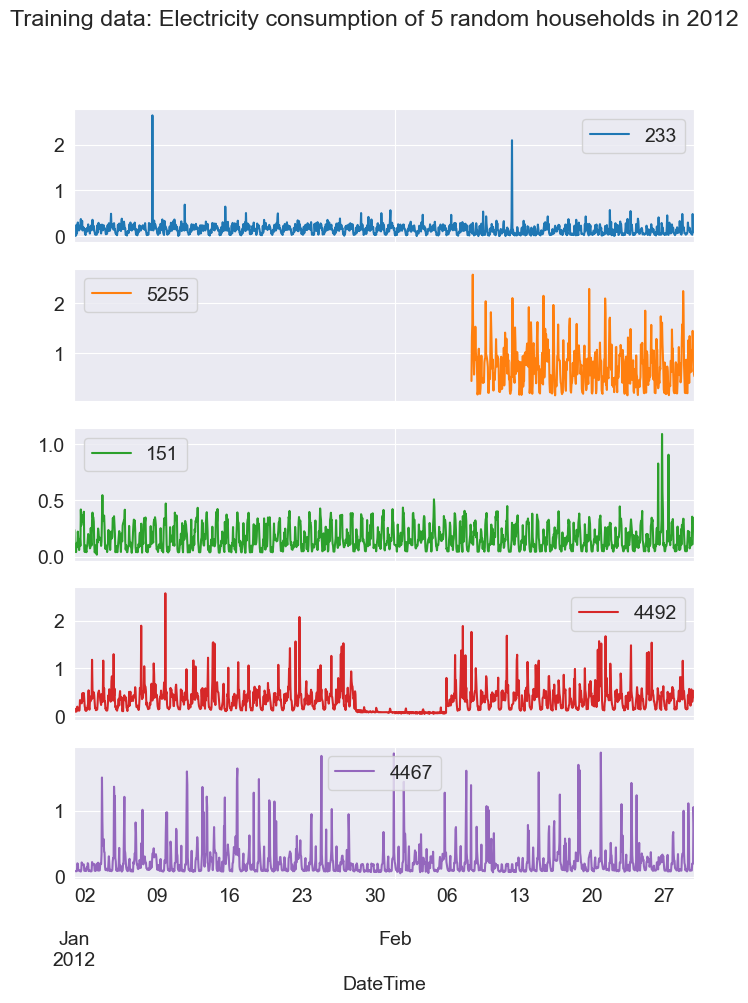

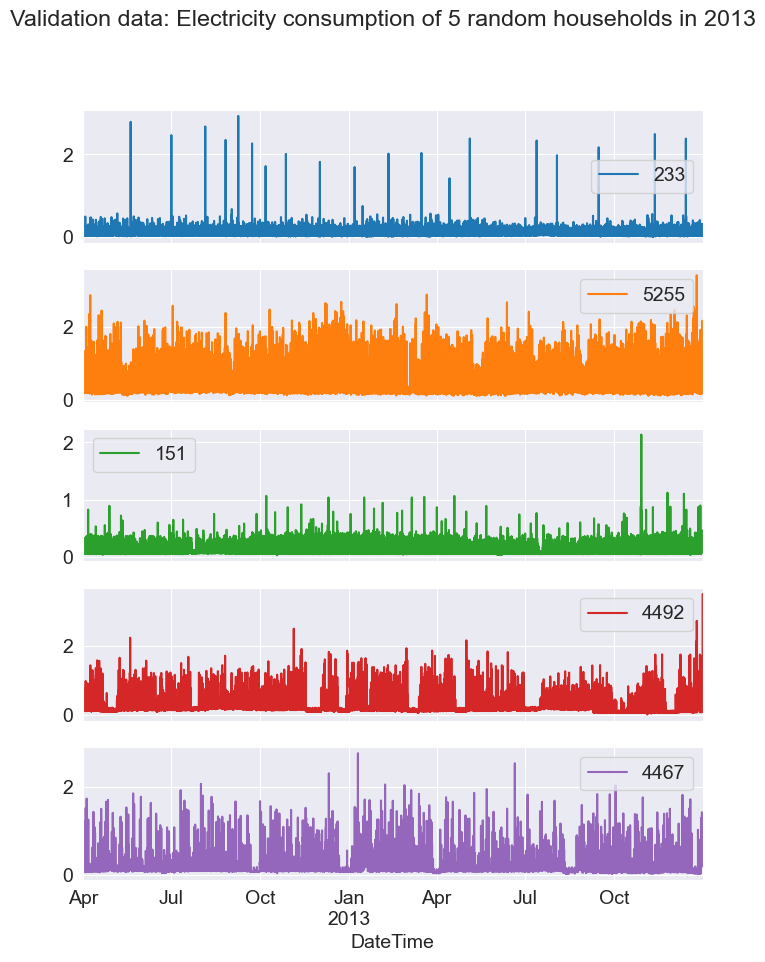

In [144]:
# Build timeseries from training dataset for random households
train_start = train_test_blocks[0]
train_end = train_test_blocks[1]
val_start = validation_data[0]
train_data = df_agg[random_households].iloc[train_start:train_end].copy()
train_data.plot(subplots=True, figsize=(8, 10), title="Training data: Electricity consumption of 5 random households in 2012")
# Build timeseries from validation dataset for random households
val_data = df_agg[random_households].iloc[val_start:].copy()
val_data.plot(subplots=True, figsize=(8, 10), title="Validation data: Electricity consumption of 5 random households in 2013")


In [156]:
# Check if selected households are in the validation dataset
assert set(random_households).issubset(val_dataset.get_all_nodes(0))


{5255, 233, 4492, 4467, 151} {3, 6, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,

In [161]:
val_dataset.get_batch_instance(0)

{2184: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2185: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2186: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2187: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2188: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2189: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2190: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2191: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2192: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2193: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2194: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2195: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2196: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[199052]),
 2197: Data(x=[1266, 1], edge_index=[2, 199052], edge_weight=[19

In [182]:
# keys of the given dataset as tensor
dataset = val_dataset.get_batch_instance(4)
indices = torch.Tensor(list(dataset.keys())).int()
batch_size = len(indices) # 128
first_idx = indices[0].item() # since it is a tensor

# Concatenate the feature tensors
x_t_matrices = dataset[first_idx].x
for i in range(first_idx + 1, first_idx + batch_size):
    x_t_matrices = torch.cat((x_t_matrices, dataset[i].x), dim = 1)

print(x_t_matrices.shape)

torch.Size([1368, 48])


# Train ARIMA models for random sample of nodes

In [ ]:
# Select node as
sarimax_models = []

for node in random_households:
    print(f"Building ARIMA model for node {node}")
    # Build ARIMA model for node
    sarimax_res = arima.build_arima_model_for_node(train_data, node, impute_data=True)
    sarimax_models.append(sarimax_res)


In [214]:
model_gvar.eval()
print(model_gvar.forecast_six_hours(val_dataset.get_batch_instance(0), 0)[0,:6])
print(utils.get_target(validation_batch_windows[0], val_dataset.get_all_nodes(0), P, df_agg)[0,:6])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0043, 0.0125])
tensor([0.1590, 0.2360, 0.1430, 0.1070, 0.2000, 0.1710])


In [216]:
val_dataset.get_all_nodes(0)

{3,
 6,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 19

In [218]:
timesteps = np.random.randint(0, len(val_dataset.get_batch_instance(0)), 3)

gvar_forecast = []
gvar_target = []
sarimax_forecast = []
for i, t in enumerate(timesteps):
    node_set = val_dataset.get_all_nodes(0)
    indices = [i for i, value in enumerate(list(node_set)) if value in random_households]
    gvar_forecast.append(model_gvar.forecast_six_hours(val_dataset.get_batch_instance(0), t)[indices, :6])
    gvar_target.append(
        utils.get_target(
            validation_batch_windows[0], node_set, P, df_agg)[indices, t:t+6]
        )
    sarimax_applied_to_val_data = sarimax_models[i].apply(df_agg[random_households[i]].iloc[val_start:val_start+2].copy())
    sarimax_forecast.append(sarimax_applied_to_val_data.forecast(steps=6))


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_m

IndexError: list index out of range

In [ ]:
batch_losses = []
for i, batch in enumerate(test_batch_windows):
    model.eval()
    optimizer.zero_grad()
    # Forward pass
    predict = model(test_dataset.get_batch_instance(i))

    target = utils.get_target(batch, test_dataset.get_all_nodes(i), P)

    loss = criterion(predict, target)
    batch_losses.append(loss.item())

Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Done.
Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Done.
Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Done.
Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Done.
Building ARIMA model for node <class 'numpy.int64'>
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Done.


In [14]:
# Apply the first SARIMAX model to unseen data of the first household
# Select the first household
node = random_households[0]
# Select the first model
sarimax_res = sarimax_models[0]
# Select the first validation data
val_data = five_households[node].iloc[val_start:].copy()

DateTime
2012-04-01 00:00:00    0.293
2012-04-01 01:00:00    0.223
2012-04-01 02:00:00    0.297
2012-04-01 03:00:00    0.219
2012-04-01 04:00:00    0.180
                       ...  
2013-12-31 19:00:00    0.363
2013-12-31 20:00:00    0.353
2013-12-31 21:00:00    0.422
2013-12-31 22:00:00    0.324
2013-12-31 23:00:00    0.363
Name: 4553, Length: 15360, dtype: float64

In [ ]:
dataset = TemporalGraphDataset(adjacency_matrix, df_agg)
for b, window_idx in enumerate(batch_windows):
    dataset.add_batch_instance(window_idx, b)

In [13]:
sarimax_res = sarimax_res.apply(val_data)

/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/saschimi/Documents/github/ml4gd-project-group-3/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [ ]:
predictions = []
# Plot seven last 7 days of fitted data and 7 days ahead (24 hours * 7 = 168)
predictions.append(sarimax_res.predict(start=train_end-168, end=val_start+168))